# **8-applied-statistics. Lab 1.1**

Михайло Корешков  
Валентина Сириця  
ФІ-91  


In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import math

import sympy

import matplotlib.pyplot as plt
import time

## Завдання 2.
Обчислити  
$\displaystyle Q_m = P(\eta > \xi_1 + ... + \xi_m)$

$\xi_i - i.i.d.$, $\eta, \xi_i$ - незалежні

$P(\eta < x) = G(x) = \mathbb{1}(x \ge 0) \left(1 - \frac{1}{1+x}\right)$  
$P(\xi_i < x) = F(x) = \mathbb{1}(x \ge 0) \left( 1-e^{-x} \right)$

Тобто $\xi_i \sim Exp(1)$.

Let $\zeta = \xi_1 + ... + \xi_m$.  
$A_m(x) = P(\zeta < x) = \sum_{k=m}^\infty \frac{x^k}{k!}e^{-x} \quad (x \ge 0)$

$\zeta \sim Erlang(m, 1)$

$a_m(x) = \frac{x^{m-1}}{(m-1)!}e^{-x}$

---

В результаті маємо 

$Q_m = P(\eta > \zeta) = \int_{y=0}^\infty \int_{x=y}^\infty \rho_\eta(x) f_\zeta(y) dx dy = \int_{x=0}^\infty (1-G(x)) \cdot \frac{x^{m-1}}{(m-1)!}e^{-x} dx$

$Q_m = \int_{x=0}^\infty \frac{1}{1+x} \cdot \frac{x^{m-1}}{(m-1)!}e^{-x} dx$

### 0. Теоретичне значення інтеграла

In [2]:
def calculate_theor(m):
    result = sympy.integrate((1/(1+u))*(u**(m-1)/(sympy.factorial(m-1)))*sympy.exp(-u), (u, 0, sympy.oo))
    val = result.evalf()
    print(f"The result of the integral (m={m}) is: {result} = {val}")
    return val

true_q = dict()
m = 1
u = sympy.Symbol('u')
for i in range(5):
    true_q[m] = calculate_theor(m)
    m *= 10

The result of the integral (m=1) is: E*expint(1, 1) = 0.596347362323194
The result of the integral (m=10) is: E*expint(10, 1) = 0.0989291326406462
The result of the integral (m=100) is: E*expint(100, 1) = 0.00999899020908473
The result of the integral (m=1000) is: E*expint(1000, 1) = 0.000999998999002009
The result of the integral (m=10000) is: E*expint(10000, 1) = 0.0000999999989999000


Перевірка генерації випадкових значень

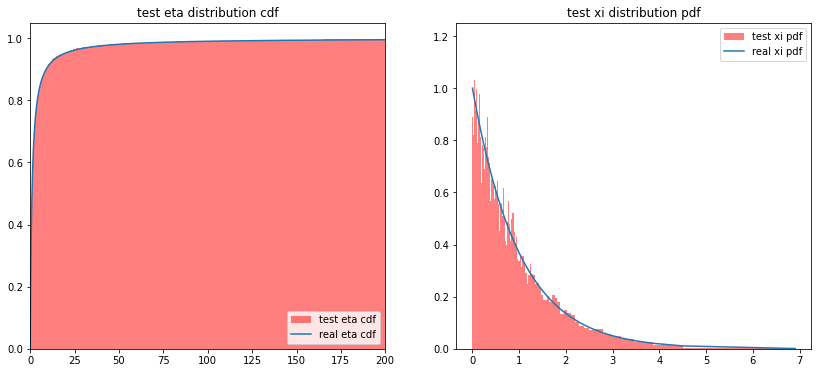

In [3]:
# m - кількість \xi в кожному наборі, N - кількість наборів (\eta, \vec \xi)
# returns eta(N), xi(m,N)
def generate(m, N):
    eta = 1/np.random.rand(N) - 1
    xi = -np.log(np.random.rand(m, N))
    return eta, xi

test_eta, test_xi = generate(1,10000)

fig, axs = plt.subplots(1,2)
bins_eta = 1/(1-np.linspace(0,0.999,1000)) - 1
axs[0].hist(test_eta, bins=bins_eta, label='test eta cdf', color='r', alpha=0.5, density=True, cumulative=True)
axs[0].plot(bins_eta, 1-1/(1+bins_eta), label='real eta cdf')
axs[0].set_xlim((0, 200))
axs[0].legend()
axs[0].set_title("test eta distribution cdf")

bins_xi = -np.log(1-np.linspace(0,0.999,100))
axs[1].hist(test_xi.T, bins=bins_xi, label='test xi pdf', color='r', alpha=0.5, density=True)
axs[1].plot(bins_xi, np.exp(-bins_xi), label='real xi pdf')
axs[1].set_title("test xi distribution pdf")
axs[1].legend()
# fig.legend()
fig.set_size_inches((14,6))

### Кількість реалізацій

In [4]:
def enough_samples(q_rvs, z=2.575, eps=0.01):
    n = q_rvs.shape[0]
    crit = ((z*z) / (eps*eps)) * (q_rvs.var(ddof=0) / np.square(q_rvs.mean()))
    return ( n > crit ), n, crit

def enough_samples_iter(n, q_rvs_mean, q_var, z=2.575, eps=0.01):
    crit = ((z*z) / (eps*eps)) * (q_var / (q_rvs_mean*q_rvs_mean))
    return ( n > crit ), n, crit

### Довірчий інтервал

In [5]:
def normal_confidence_interval(n, mean, var, gamma):
    z = sp.stats.norm.ppf(1-(gamma/2))
    semiinterval = np.sqrt(var) * z / np.sqrt(n)
    a = mean - semiinterval
    b = mean + semiinterval
    return (a,b)

### Метод 1
Звичайний Монте-Карло.

Генеруємо багато вибірок виду $(\eta^i, \xi_1^i, ..., \xi_m^i)$.  
$Q_m = M \mathbf 1 (\eta > \xi_1 + ... + \xi_m) \approx mean(\mathbf 1 (\eta^i > \xi^i_1 + ... + \xi^i_m)) $

In [6]:
def mc1(m, N, n0=100):
    print(f'monte-carlo-1 (m={m}, N={N}, n0={n0})')
    if N < n0:
        print("Error. N < n0.")
        return

    # random outcomes
    eta, xis = generate(m, N)

    # which of outcomes are positive
    q_rvs = eta > xis.sum(axis=0)

    # estimate of Q
    Q_est = q_rvs.mean()
    Q_var = q_rvs.var(ddof=1)

    conf = normal_confidence_interval(N, Q_est, Q_var, 0.05)
    print(f'> Q estimate = {Q_est:.5f};  Variance of q = {Q_var:.5f}')
    print(f'> Confidence interval ({conf[0]:.5f} ; {conf[1]:.5f})')
    if m in true_q:
        print(f'> True value of Q = {true_q[m]:.5f}; ', end='')
        if conf[0] < true_q[m] < conf[1]:
            print('OK - In confidence interval')
        else:
            print('NOT In confidence interval')

    prec = enough_samples_iter(N, Q_est, Q_var)
    if prec[0]:
        print(f"> Enough number of samples (n={prec[1]:.3f} > n*={prec[2]:.3f})")
    else:
        print(f"> NOT Enough number of samples  (n={prec[1]:.3f} < n*={prec[2]:.3f})")
    
    error = (Q_est - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')

In [7]:
def mc1_iter(m, N, n0, batch_size=10_000):
    print(f'monte-carlo-1 [batched] (m={m}, N={N}, n0={n0})')
    if N < n0:
        print("Error. N < n0.")
        return

    n_epochs = int(N / batch_size)
    N0 = n_epochs * batch_size
    N_left = N

    q_all = np.array([], np.float64)

    epoch_counter = 1
    t0 = time.time()
    t1 = None
    while N_left > 0:
        t0_b = time.time()
        N_local = min(batch_size, N_left)

        eta, xis = generate(m, N_local)
        q_all = np.append(q_all, eta > xis.sum(axis=0)) # \hat q_i defined here
        t1 = time.time()
        
        N_left -= N_local
        print(f'batch {epoch_counter}/{n_epochs} : {N_left} left (took {(t1-t0_b)})')
        epoch_counter += 1
        
    print(f"total phase 1 time = {t1-t0}")
    print(f"starting phase 2")

    t0 = time.time()

    # estimate of Q
    Q_est = q_all.mean()
    Q_var = q_all.var(ddof=1)

    conf = normal_confidence_interval(N, Q_est, Q_var, 0.05)
    print(f'> Q estimate = {Q_est:.5f};  Variance of q = {Q_var:.5f}')
    print(f'> Confidence interval ({conf[0]:.5f} ; {conf[1]:.5f})')
    if m in true_q:
        print(f'> True value of Q = {true_q[m]:.5f}; ', end='')
        if conf[0] < true_q[m] < conf[1]:
            print('OK - In confidence interval')
        else:
            print('NOT In confidence interval')

    prec = enough_samples_iter(N, Q_est, Q_var)
    if prec[0]:
        print(f"> Enough number of samples (n={prec[1]:.3f} > n*={prec[2]:.3f})")
    else:
        print(f"> NOT Enough number of samples  (n={prec[1]:.3f} < n*={prec[2]:.3f})")
    
    error = (Q_est - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')


In [8]:
mc1(1, 50_000, n0=0)

monte-carlo-1 (m=1, N=50000, n0=0)
> Q estimate = 0.59788;  Variance of q = 0.24042
> Confidence interval (0.59358 ; 0.60218)
> True value of Q = 0.59635; OK - In confidence interval
> Enough number of samples (n=50000.000 > n*=44596.913)
> error = 0.00153 (0.003%)


In [9]:
mc1(10, 700_000)

monte-carlo-1 (m=10, N=700000, n0=100)
> Q estimate = 0.09909;  Variance of q = 0.08927
> Confidence interval (0.09839 ; 0.09979)
> True value of Q = 0.09893; OK - In confidence interval
> Enough number of samples (n=700000.000 > n*=602865.687)
> error = 0.00016 (0.002%)


In [10]:
mc1_iter(100, 6_000_000, n0=1000, batch_size=1_000_000)

monte-carlo-1 [batched] (m=100, N=6000000, n0=1000)
batch 1/6 : 5000000 left (took 1.9973549842834473)
batch 2/6 : 4000000 left (took 2.0577406883239746)
batch 3/6 : 3000000 left (took 1.8260447978973389)
batch 4/6 : 2000000 left (took 1.8897273540496826)
batch 5/6 : 1000000 left (took 1.9241936206817627)
batch 6/6 : 0 left (took 1.8680498600006104)
total phase 1 time = 11.563111305236816
starting phase 2
> Q estimate = 0.01002;  Variance of q = 0.00992
> Confidence interval (0.00994 ; 0.01010)
> True value of Q = 0.01000; OK - In confidence interval
> NOT Enough number of samples  (n=6000000.000 < n*=6551305.208)
> error = 0.00002 (0.002%)


In [11]:
mc1_iter(100, 7_000_000, n0=1000, batch_size=1_000_000)

monte-carlo-1 [batched] (m=100, N=7000000, n0=1000)
batch 1/7 : 6000000 left (took 1.8173809051513672)
batch 2/7 : 5000000 left (took 1.792524814605713)
batch 3/7 : 4000000 left (took 1.8504531383514404)
batch 4/7 : 3000000 left (took 1.8665757179260254)
batch 5/7 : 2000000 left (took 1.8238964080810547)
batch 6/7 : 1000000 left (took 1.8837153911590576)
batch 7/7 : 0 left (took 1.8795034885406494)
total phase 1 time = 12.915058135986328
starting phase 2
> Q estimate = 0.01001;  Variance of q = 0.00991
> Confidence interval (0.00994 ; 0.01009)
> True value of Q = 0.01000; OK - In confidence interval
> Enough number of samples (n=7000000.000 > n*=6555333.177)
> error = 0.00001 (0.001%)


In [12]:
mc1_iter(1000, 10_000_000, n0=0, batch_size=100_000)

monte-carlo-1 [batched] (m=1000, N=10000000, n0=0)
batch 1/100 : 9900000 left (took 1.6591386795043945)
batch 2/100 : 9800000 left (took 1.6829383373260498)
batch 3/100 : 9700000 left (took 1.7560462951660156)
batch 4/100 : 9600000 left (took 1.7463362216949463)
batch 5/100 : 9500000 left (took 1.7614293098449707)
batch 6/100 : 9400000 left (took 1.7400431632995605)
batch 7/100 : 9300000 left (took 1.7161405086517334)
batch 8/100 : 9200000 left (took 1.751671314239502)
batch 9/100 : 9100000 left (took 1.7381083965301514)
batch 10/100 : 9000000 left (took 1.7098050117492676)
batch 11/100 : 8900000 left (took 1.7114267349243164)
batch 12/100 : 8800000 left (took 1.7522144317626953)
batch 13/100 : 8700000 left (took 1.7115509510040283)
batch 14/100 : 8600000 left (took 1.7128126621246338)
batch 15/100 : 8500000 left (took 1.7579867839813232)
batch 16/100 : 8400000 left (took 1.7937829494476318)
batch 17/100 : 8300000 left (took 1.713088035583496)
batch 18/100 : 8200000 left (took 1.756944

### Метод 2

$\hat q_i = \frac{1}{1 + \xi^{(i)}_1 + ... + \xi^{(i)}_n}$


In [13]:
def mc2_iter(m, N, n0=0, batch_size=10_000):
    print(f'monte-carlo-2 [batched] (m={m}, N={N}, n0={n0})')
    if N < n0:
        print("Error. N < n0.")
        return

    n_epochs = int(N / batch_size)
    N0 = n_epochs * batch_size
    N_left = N

    q_all = np.array([], np.float64)

    epoch_counter = 1
    t0 = time.time()
    t1 = None
    while N_left > 0:
        t0_b = time.time()
        N_local = min(batch_size, N_left)

        eta, xis = generate(m, N_local)
        q_all = np.append(q_all, (1 / (1 + xis.sum(axis=0))) ) # \hat q_i defined here
        t1 = time.time()
        
        N_left -= N_local
        print(f'batch {epoch_counter}/{n_epochs} : {N_left} left (took {(t1-t0_b)})')
        epoch_counter += 1
        
    print(f"total phase 1 time = {t1-t0}")
    print(f"starting phase 2")

    t0 = time.time()

    # estimate of Q
    Q_est = q_all.mean()
    Q_var = q_all.var(ddof=1)

    conf = normal_confidence_interval(N, Q_est, Q_var, 0.05)
    print(f'> Q estimate = {Q_est:.5f};  Variance of q = {Q_var:.5f}')
    print(f'> Confidence interval ({conf[0]:.5f} ; {conf[1]:.5f})')
    if m in true_q:
        print(f'> True value of Q = {true_q[m]:.5f}; ', end='')
        if conf[0] < true_q[m] < conf[1]:
            print('OK - In confidence interval')
        else:
            print('NOT In confidence interval')

    prec = enough_samples_iter(N, Q_est, Q_var)
    if prec[0]:
        print(f"> Enough number of samples (n={prec[1]:.3f} > n*={prec[2]:.3f})")
    else:
        print(f"> NOT Enough number of samples  (n={prec[1]:.3f} < n*={prec[2]:.3f})")
    
    error = (Q_est - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')


In [14]:
mc2_iter(m=1, N=10_000)

monte-carlo-2 [batched] (m=1, N=10000, n0=0)
batch 1/1 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.59629;  Variance of q = 0.04783
> Confidence interval (0.59200 ; 0.60057)
> True value of Q = 0.59635; OK - In confidence interval
> Enough number of samples (n=10000.000 > n*=8920.364)
> error = -0.00006 (-0.000%)


In [15]:
mc2_iter(m=10, N=10_000)

monte-carlo-2 [batched] (m=10, N=10000, n0=0)
batch 1/1 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.09899;  Variance of q = 0.00090
> Confidence interval (0.09840 ; 0.09957)
> True value of Q = 0.09893; OK - In confidence interval
> Enough number of samples (n=10000.000 > n*=6057.085)
> error = 0.00006 (0.001%)


In [27]:
mc2_iter(m=100, N=1000)

monte-carlo-2 [batched] (m=100, N=1000, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.00998;  Variance of q = 0.00000
> Confidence interval (0.00992 ; 0.01005)
> True value of Q = 0.01000; OK - In confidence interval
> Enough number of samples (n=1000.000 > n*=666.509)
> error = -0.00002 (-0.002%)


In [26]:
mc2_iter(m=1000, N=100)

monte-carlo-2 [batched] (m=1000, N=100, n0=0)
batch 1/0 : 0 left (took 0.006180763244628906)
total phase 1 time = 0.006180763244628906
starting phase 2
> Q estimate = 0.00100;  Variance of q = 0.00000
> Confidence interval (0.00099 ; 0.00100)
> True value of Q = 0.00100; OK - In confidence interval
> Enough number of samples (n=100.000 > n*=64.269)
> error = -0.00000 (-0.003%)


### Метод 3

$\displaystyle \hat q_i = \frac{1}{m-1} \cdot \frac{n \overline{\xi^{(i)}}}{1 + n \overline{\xi^{(i)}}}$

In [18]:
def mc3_iter(m, N, n0=0, batch_size=10_000):
    print(f'monte-carlo-3 [batched] (m={m}, N={N}, n0={n0})')
    if N < n0:
        print("Error. N < n0.")
        return

    n_epochs = int(N / batch_size)
    N0 = n_epochs * batch_size
    N_left = N

    q_all = np.array([], np.float64)

    epoch_counter = 1
    t0 = time.time()
    t1 = None
    while N_left > 0:
        t0_b = time.time()
        N_local = min(batch_size, N_left)

        eta, xis = generate( (m-1), N_local) # NB! (m-1) instead of m
        xi_sum = xis.sum(axis=0)
        q_all = np.append(q_all, xi_sum / ((m - 1) * (1 + xi_sum)) )  # \hat q_i defined here
        t1 = time.time()
        
        N_left -= N_local
        print(f'batch {epoch_counter}/{n_epochs} : {N_left} left (took {(t1-t0_b)})')
        epoch_counter += 1
        
    print(f"total phase 1 time = {t1-t0}")
    print(f"starting phase 2")

    t0 = time.time()

    # estimate of Q
    Q_est = q_all.mean()

    if N == 1:
        print('Single iteration result:')
        print(f'> Q estimate = {Q_est:.5f};')
        if m in true_q:
            print(f'> True value of Q = {true_q[m]:.5f}; ', end='')
            error = (Q_est - true_q[m])
            print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')
        return
        
    Q_var = q_all.var(ddof=1)

    conf = normal_confidence_interval(N, Q_est, Q_var, 0.05)
    print(f'> Q estimate = {Q_est:.5f};  Variance of q = {Q_var:.5f}')
    print(f'> Confidence interval ({conf[0]:.5f} ; {conf[1]:.5f})')
    if m in true_q:
        print(f'> True value of Q = {true_q[m]:.5f}; ', end='')
        if conf[0] < true_q[m] < conf[1]:
            print('OK - In confidence interval')
        else:
            print('NOT In confidence interval')

    prec = enough_samples_iter(N, Q_est, Q_var)
    if prec[0]:
        print(f"> Enough number of samples (n={prec[1]:.3f} > n*={prec[2]:.3f})")
    else:
        print(f"> NOT Enough number of samples  (n={prec[1]:.3f} < n*={prec[2]:.3f})")
    
    error = (Q_est - true_q[m])
    print(f'> error = {error:.5f} ({error/true_q[m]:.3f}%)')


In [19]:
mc3_iter(m=10, N=100)

monte-carlo-3 [batched] (m=10, N=100, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.09898;  Variance of q = 0.00001
> Confidence interval (0.09829 ; 0.09966)
> True value of Q = 0.09893; OK - In confidence interval
> Enough number of samples (n=100.000 > n*=83.635)
> error = 0.00005 (0.000%)


In [20]:
mc3_iter(m=10, N=200)

monte-carlo-3 [batched] (m=10, N=200, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.09916;  Variance of q = 0.00002
> Confidence interval (0.09858 ; 0.09974)
> True value of Q = 0.09893; OK - In confidence interval
> Enough number of samples (n=200.000 > n*=117.441)
> error = 0.00023 (0.002%)


In [21]:
mc3_iter(m=100, N=1)

monte-carlo-3 [batched] (m=100, N=1, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
Single iteration result:
> Q estimate = 0.01001;
> True value of Q = 0.01000; > error = 0.00001 (0.001%)


In [22]:
mc3_iter(m=100, N=3)

monte-carlo-3 [batched] (m=100, N=3, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.01000;  Variance of q = 0.00000
> Confidence interval (0.01000 ; 0.01001)
> True value of Q = 0.01000; OK - In confidence interval
> Enough number of samples (n=3.000 > n*=0.028)
> error = 0.00000 (0.000%)


In [23]:
mc3_iter(m=1000, N=1)

monte-carlo-3 [batched] (m=1000, N=1, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
Single iteration result:
> Q estimate = 0.00100;
> True value of Q = 0.00100; > error = 0.00000 (0.000%)


In [24]:
mc3_iter(m=1000, N=3)

monte-carlo-3 [batched] (m=1000, N=3, n0=0)
batch 1/0 : 0 left (took 0.0)
total phase 1 time = 0.0
starting phase 2
> Q estimate = 0.00100;  Variance of q = 0.00000
> Confidence interval (0.00100 ; 0.00100)
> True value of Q = 0.00100; NOT In confidence interval
> Enough number of samples (n=3.000 > n*=0.000)
> error = -0.00000 (-0.000%)
